In [459]:
import sys
sys.path.insert(0, '..')

In [460]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [461]:
wid = 80
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)


data = '../data/MAST_2024-09-19T06_48_02.332Z/HST/'

data = '../data/MAST_2024-09-23T06_53_22.463Z/HST/'


exposures = [

    # N458
    #exposure_from_file(data+'na2a05ttq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a05tuq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05txq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05tzq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05u2q_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05u4q_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05u7q_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05u9q_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05ueq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05uhq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05ujq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05umq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05uoq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05urq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05utq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05uwq_cal.fits", SinglePointFit(), crop=wid),
    #exposure_from_file(data+"na2a05uxq_cal.fits", SinglePointFit(), crop=wid),


    # N581
    exposure_from_file(data+'na2a04maq_cal.fits', SinglePointFit(), crop=wid),
    exposure_from_file(data+'na2a04mbq_cal.fits', SinglePointFit(), crop=wid),
    exposure_from_file(data+'na2a04meq_cal.fits', SinglePointFit(), crop=wid),
    exposure_from_file(data+'na2a04mgq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mjq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mlq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04moq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mqq_cal.fits', SinglePointFit(), crop=wid),


    #exposure_from_file(data+'na2a04mcq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mdq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mhq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04miq_cal.fits', SinglePointFit(), crop=wid),
]

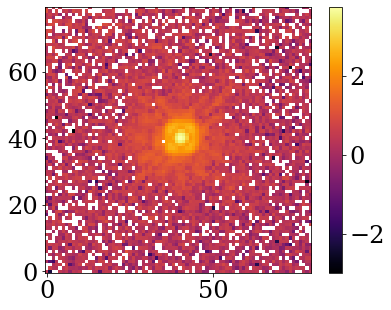

In [462]:
n = 0
plt.imshow(np.log10(exposures[n].data/exposures[n].err))
plt.colorbar()

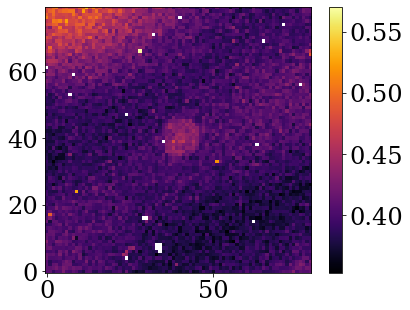

In [463]:
plt.imshow(exposures[0].err)
plt.colorbar()

In [464]:
params = {
    "fluxes": {},
    "positions": {},
    "slope": {},
    "contrast": {},
    #"separation": 6.,#18.,
    #"position_angle": 45.,#30.,#80.,#40.,
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    #"scale": 0.0434735,
    #"rot": 0.0
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])#np.asarray([-6.,-7.])#np.asarray([-8.,-2.])#np.asarray([-6.,-7.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    params["slope"][exp.fit.get_key(exp, "slope")] = np.zeros(5)#.at[0].set(1)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = 45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = 45.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["contrast"][exp.fit.get_key(exp, "contrast")] = 1.


model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [465]:
params

ModelParams(
  params={
    'fluxes':
    {'F110W': f32[]},
    'positions':
    {
      'na2a04maq':
      f32[2],
      'na2a04mbq':
      f32[2],
      'na2a04meq':
      f32[2],
      'na2a04mgq':
      f32[2]
    },
    'slope':
    {'F110W': f32[5]},
    'contrast':
    {},
    'aberrations':
    {
      'na2a04maq':
      f32[26],
      'na2a04mbq':
      f32[26],
      'na2a04meq':
      f32[26],
      'na2a04mgq':
      f32[26]
    },
    'cold_mask_shift':
    {'F110W': f32[2]},
    'cold_mask_rot':
    {'F110W': 45.0},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_rot':
    {'F110W': 45.0},
    'primary_shear':
    {'F110W': f32[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924
  }
)

In [466]:
print(params.params)

{'fluxes': {'F110W': Array(4.471614, dtype=float32)}, 'positions': {'na2a04maq': Array([0., 0.], dtype=float32), 'na2a04mbq': Array([0., 0.], dtype=float32), 'na2a04meq': Array([0., 0.], dtype=float32), 'na2a04mgq': Array([0., 0.], dtype=float32)}, 'slope': {'F110W': Array([0., 0., 0., 0., 0.], dtype=float32)}, 'contrast': {}, 'aberrations': {'na2a04maq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'na2a04mbq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'na2a04meq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'na2a04mgq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'cold_mask_shift': {'F110W': Array([6., 6.], dtype=float32)}, 

In [467]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 2e-4

things = {
    "fluxes" : opt(g*100,20),
    "positions": opt(g*5, 0),
    "cold_mask_shift": opt(g*2000, 40),
    "cold_mask_scale": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 40),
    "cold_mask_shear": opt(g*500, 40),
    #"primary_scale": opt(g*1000, 200),
    #"primary_rot": opt(g*1000, 200),
    #"primary_shear": opt(g*1000, 200),
    "aberrations": opt(g*10,40),
    "slope": opt(g*1000, 60),
    #"separation": opt(g*30, 0),
    #"contrast": opt(g*20, 20),
    #"position_angle": opt(g*20, 0)
    #"rot": opt(g*100, 50),
    #"spider_width": opt(g*500, 60),
}

g = 6e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*3, 0),
    "cold_mask_shift": opt(g*100, 120),
    "cold_mask_rot": opt(g*100, 120),
    "cold_mask_scale": opt(g*1000, 150),
    "cold_mask_shear": opt(g*10, 150),
    "primary_scale": opt(g*100, 150),
    "primary_rot": opt(g*100, 150),
    "primary_shear": opt(g*100, 150),
    "aberrations": opt(g*10,120),
    "slope": opt(g*20, 50),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [468]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [469]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [470]:
lrs.params

{'aberrations': {'na2a04maq': Array([0.00059434, 0.0003753 , 0.00031563, 0.00055471, 0.00059978,
         0.00066765, 0.00067125, 0.0008068 , 0.00032082, 0.00039853,
         0.00047869, 0.00041997, 0.00058911, 0.00056331, 0.00044402,
         0.00044197, 0.00052388, 0.00052948, 0.00042585, 0.00040268,
         0.00032299, 0.00030989, 0.00035738, 0.00053864, 0.00045782,
         0.00047692], dtype=float32),
  'na2a04mbq': Array([0.00059142, 0.00037432, 0.00031501, 0.00055758, 0.00058107,
         0.00065923, 0.00066572, 0.00080258, 0.00031887, 0.00039578,
         0.00047629, 0.00041799, 0.00057794, 0.00056367, 0.0004408 ,
         0.00043812, 0.00052118, 0.00052717, 0.00042456, 0.00040067,
         0.00032164, 0.00030854, 0.00035585, 0.00053721, 0.00045632,
         0.00047763], dtype=float32),
  'na2a04meq': Array([0.00053357, 0.0003378 , 0.00028677, 0.00047516, 0.00050945,
         0.00056509, 0.00056599, 0.00072077, 0.00028882, 0.00035623,
         0.00043341, 0.00037986, 0.0005154

In [471]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(400)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/400 [00:00<?, ?it/s]

In [472]:
model


NICMOSModel(
  params={
    'aberrations':
    {
      'na2a04maq':
      f32[26],
      'na2a04mbq':
      f32[26],
      'na2a04meq':
      f32[26],
      'na2a04mgq':
      f32[26]
    },
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'F110W': f32[2]},
    'contrast':
    {},
    'fluxes':
    {'F110W': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {
      'na2a04maq':
      f32[2],
      'na2a04mbq':
      f32[2],
      'na2a04meq':
      f32[2],
      'na2a04mgq':
      f32[2]
    },
    'primary_rot':
    {'F110W': f32[]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'secondary_radius':
    f32[],
    'slope':
    {'F110W': f32[5]},
    'spider_width':
    f32[]
  },
  filters={'F110W': f32[15,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundAperture':
      C

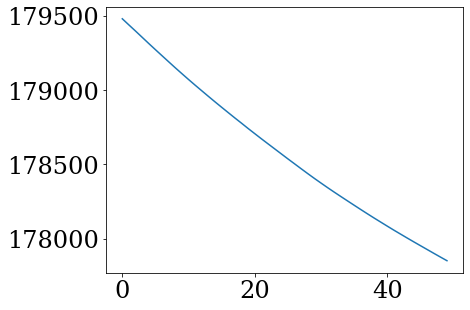

In [473]:
plt.plot(losses[-50:])

In [474]:
params.params

{'aberrations': {'na2a04maq': Array([ 0.38031572, -0.10836495,  0.35833403, -0.44687745,  5.510286  ,
          1.4708583 , -1.6148138 , -1.5020072 , -0.6077722 ,  0.389677  ,
          0.05011616, -0.64279056, -3.6164105 , -0.91302824, -0.92301065,
         -3.366834  ,  0.35369036, -0.75914776,  0.04326678,  1.4659836 ,
         -0.71437097,  0.37575856,  0.91401714,  0.6012798 ,  0.14846687,
         -0.04547875], dtype=float32),
  'na2a04mbq': Array([ 0.7196826 , -0.3488201 ,  0.44285935,  0.0763585 ,  5.8031898 ,
          1.7973886 , -2.033914  , -1.2840254 , -1.0148424 ,  0.28608656,
          0.14572424, -0.7190272 , -3.5869553 , -1.1742927 , -1.1638002 ,
         -3.228022  ,  0.5603008 , -1.6348175 , -0.253914  ,  1.7135137 ,
         -0.76671666,  0.3714804 ,  0.76875   ,  0.87815434,  0.5493329 ,
         -0.49544683], dtype=float32),
  'na2a04meq': Array([ 0.31584182,  0.39403275,  0.6455957 ,  2.410315  ,  4.9986453 ,
         -0.1716758 ,  3.2387989 , -1.0688418 , -0.824

11


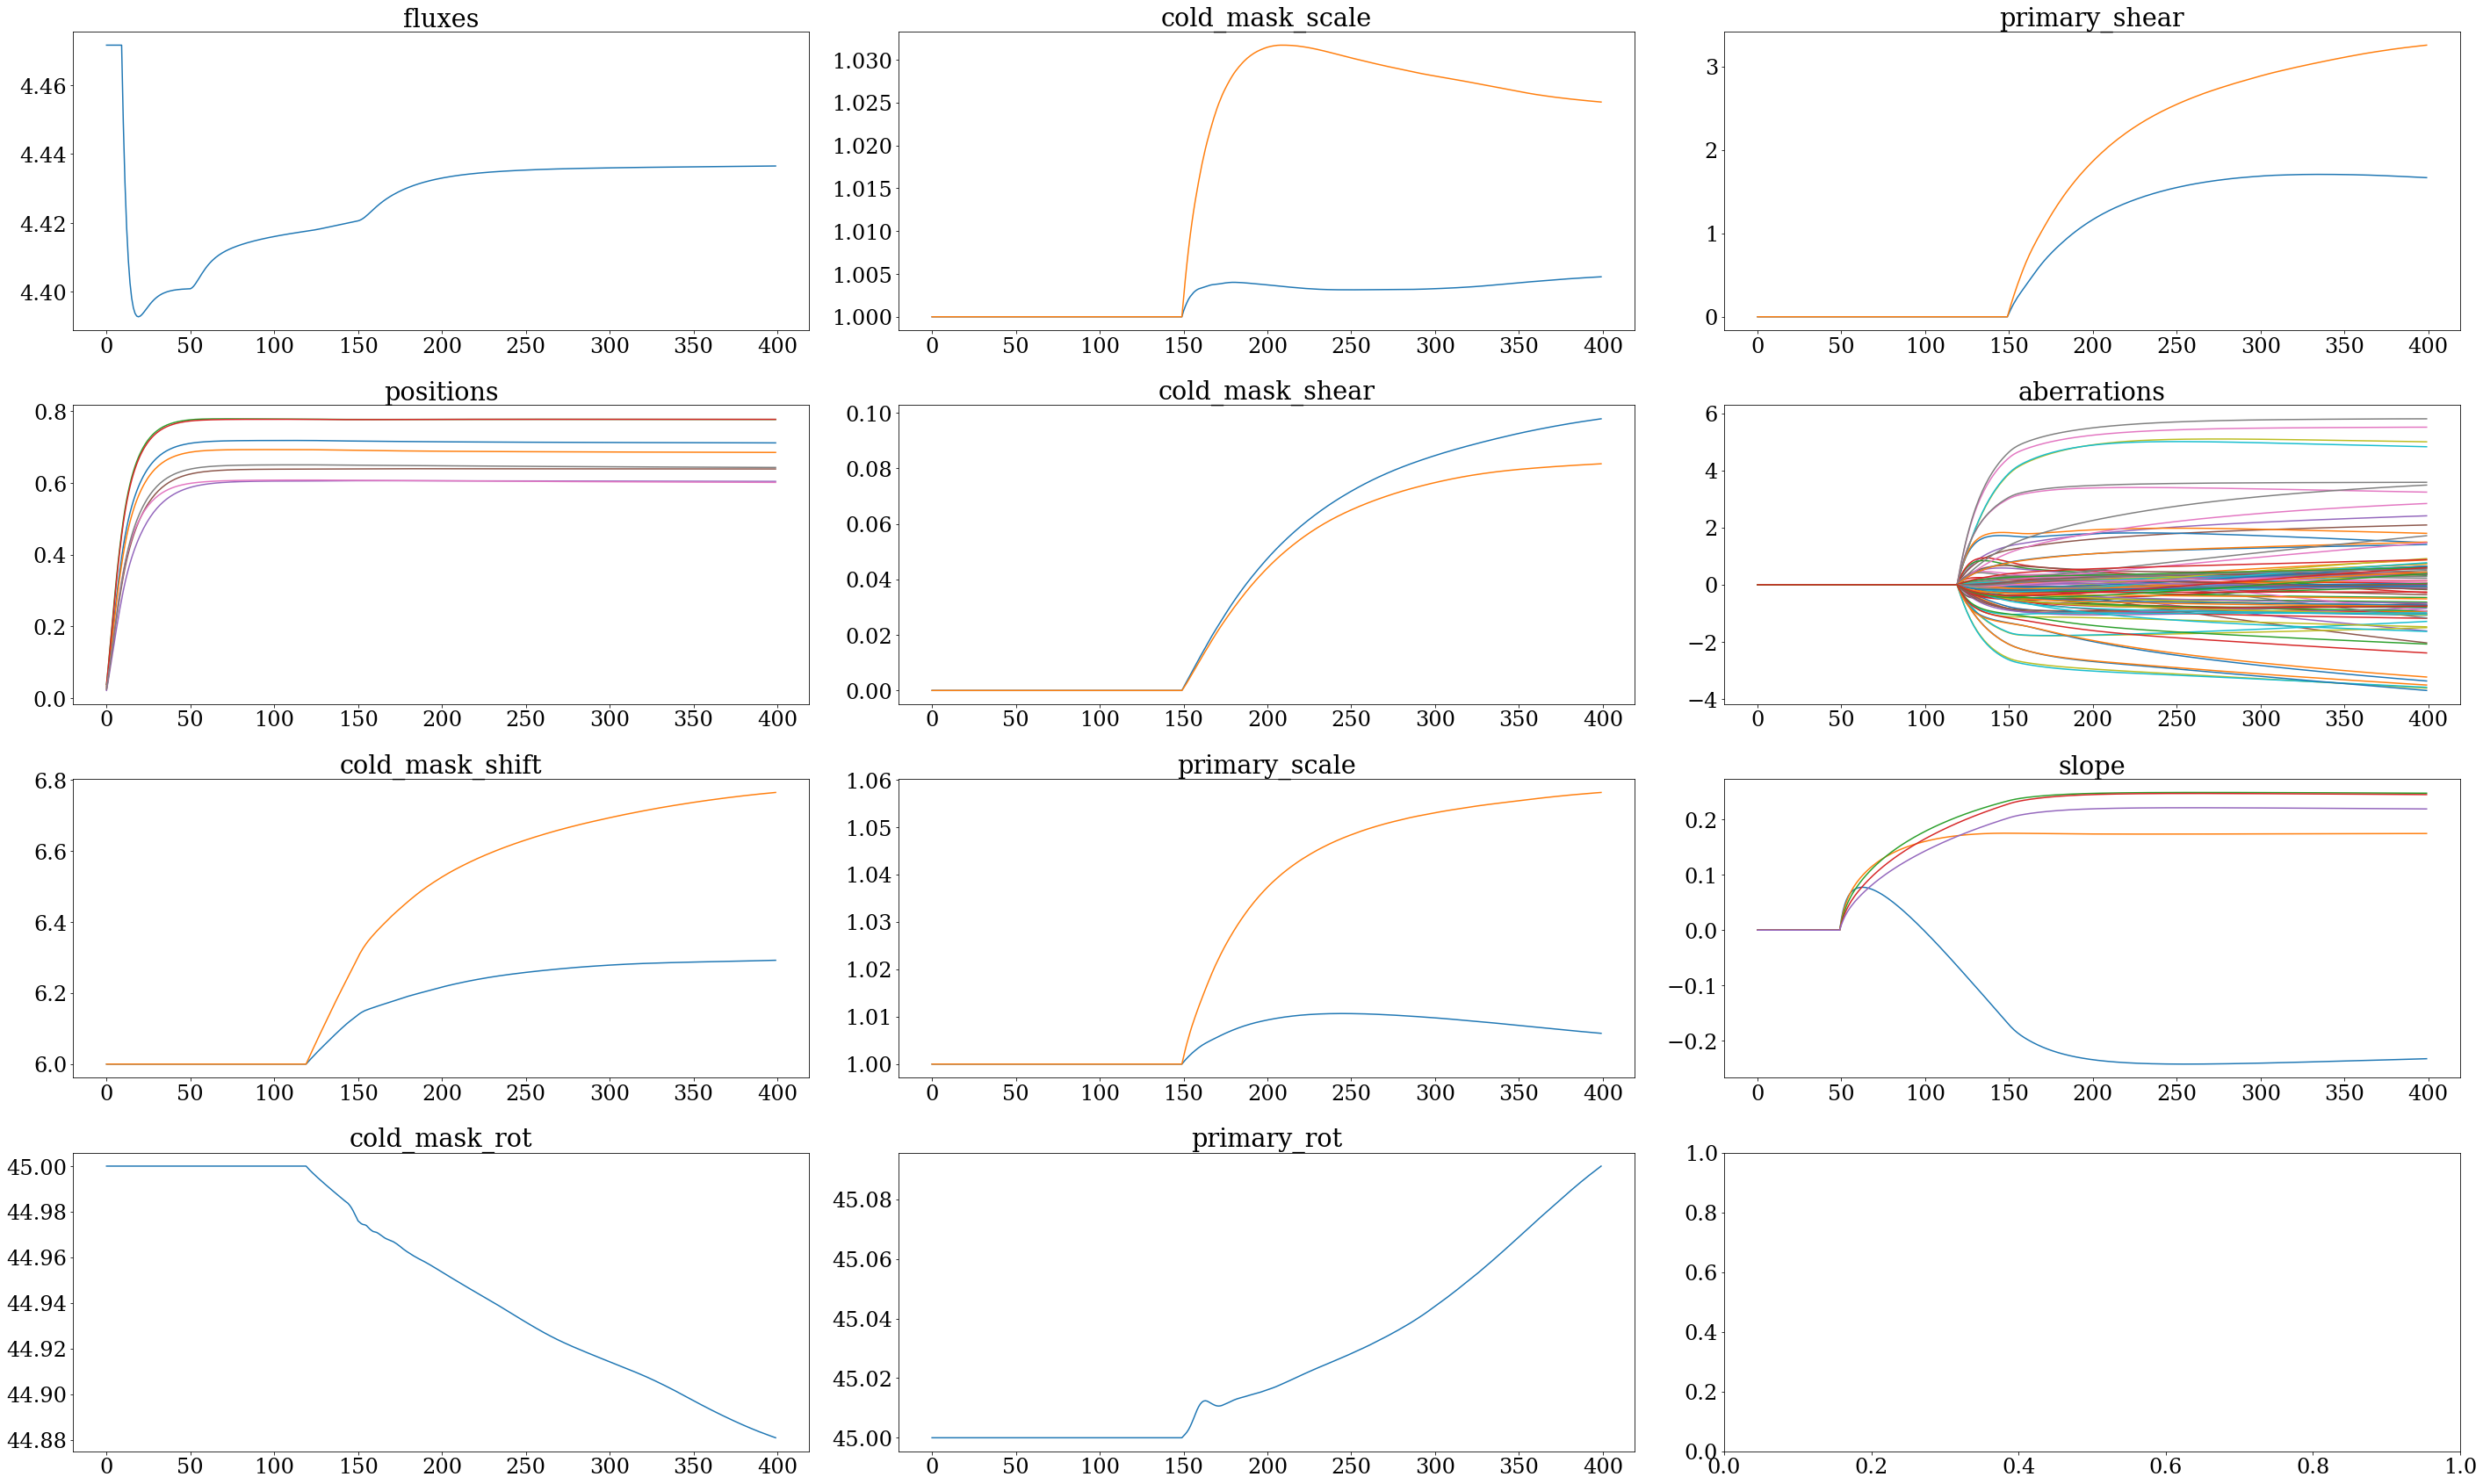

In [475]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "slope"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

1.201511e+08, 1.778524e+05


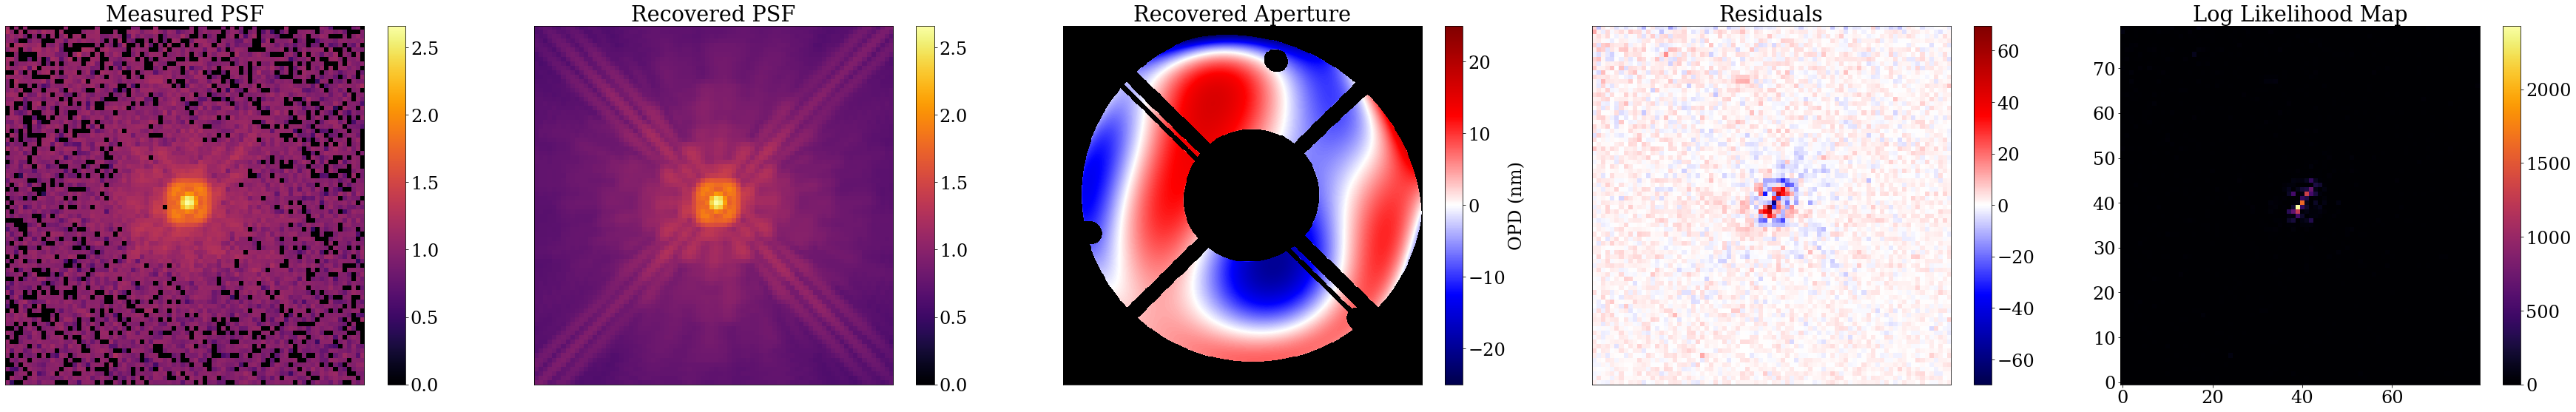

In [476]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

"""def pix2rad(x):
    return dlu.arcsec2rad(x*0.0432)

def rad2pix(x):
    return dlu.rad2arcsec(x)/0.0432

positions = dlu.positions_from_sep(
        pix2rad(model.get(exp.map_param("positions"))),
        pix2rad(model.params["separation"]),
        dlu.deg2rad(model.params["position_angle"])
    )

for i in range(2):
    x, y = rad2pix(positions[i]) + wid/2 - 0.5
    axs[3].axvline(x, color='gk'[i],linestyle='--')
    axs[3].axhline(y, color='gk'[i],linestyle='--')
"""

lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")


for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [477]:
#resid = (exp.data - exp.fit(model,exp))/exp.data
#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
#plt.colorbar()

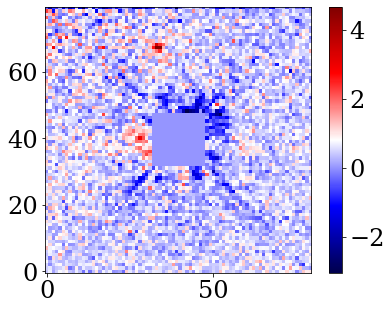

In [496]:
res = 0.0
for exp in exposures:#[:10]+exposures[11:]:
    res = res + np.nan_to_num(exp.data - exp.fit(model, exp), 0.0)/len(exposures)

res = res.at[32:48,32:48].set(0.0)

m = np.max(np.abs(res))

plt.imshow((res), cmap='seismic')#, vmax=m, vmin=-m)
plt.colorbar()

2982.0916


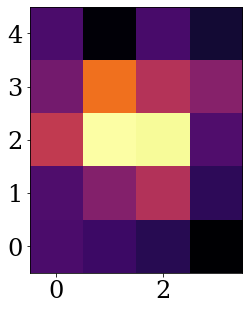

In [491]:
#plt.imshow(res[21:25,64:68])
#print(10**4.9665546 / np.sum(res[21:25,64:68]))
# gives 2223.365 for N458

plt.imshow(res[65:70, 32:36])
print(10**4.4365478 / np.sum(res[21:25,64:68]))
